In [2]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.ToTensor()

# Training set
train_dataset = CIFAR10(
    root="/datasets01/cifar-pytorch/11222017",
    train=True,
    download=False,
    transform=transform,
)

# Test set
test_dataset = CIFAR10(
    root="/datasets01/cifar-pytorch/11222017",
    train=False,
    download=False,
    transform=transform,
)

# construct dataloader

train_batch_size = 128
test_batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
)


test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
)

In [12]:
from models.model_configs import instantiate_model
import torch

def create_model():
    """
    Returns a UNetModel configured for CIFAR10.
    """
    return instantiate_model('cifar10', is_discrete=False, use_ema=False)


In [13]:
from torch.optim import AdamW

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

path = AffineProbPath(scheduler=CondOTScheduler())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fm = create_model().to(device)
lr = 0.005
optim = AdamW(params=fm.parameters(), lr=lr)
loss_fn = nn.MSELoss()

num_epochs = 100  # or just count iterations if you want

for epoch in range(num_epochs):
    # -------- Training --------
    fm.train()
    train_loss = 0
    train_batches = 0
    for batch in train_loader:
        x_1 = batch[0].to(device)
        x_0 = torch.randn_like(x_1).to(device)

        B, C, H, W = x_0.shape
        t = torch.rand(B, device=device)
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        
        t = path_sample.t
        t = t.view(B, 1, 1, 1)
        
        x_t = path_sample.x_t
        dx_t = path_sample.dx_t
        

        pred = fm(x_t, t)
        loss = loss_fn(pred, dx_t)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss += loss.item()
        train_batches += 1

    avg_train_loss = train_loss / train_batches

    # -------- Validation --------
    fm.eval()
    val_loss = 0
    val_batches = 0
    with torch.no_grad():
        for batch in test_loader:
            x_1 = batch[0].to(device)
            x_0 = torch.randn_like(x_1).to(device)

            B, C, H, W = x_0.shape
            t = torch.rand(B, 1, 1, 1, device=device)
            x_t = (1 - t) * x_0 + t * x_1
            d_xt = x_1 - x_0

            pred = fm(x_t, t)
            loss = loss_fn(pred, d_xt)

            val_loss += loss.item()
            val_batches += 1

    avg_val_loss = val_loss / val_batches

    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.5f} | Val Loss = {avg_val_loss:.5f}")


Epoch 0: Train Loss = 1.08567 | Val Loss = 1.06256
Epoch 1: Train Loss = 0.92926 | Val Loss = 0.73894
Epoch 2: Train Loss = 0.72358 | Val Loss = 0.70916
Epoch 3: Train Loss = 0.70191 | Val Loss = 0.69313
Epoch 4: Train Loss = 0.67373 | Val Loss = 0.66023
Epoch 5: Train Loss = 0.65600 | Val Loss = 0.65394
Epoch 6: Train Loss = 0.64580 | Val Loss = 0.65142
Epoch 7: Train Loss = 0.63748 | Val Loss = 0.66884
Epoch 8: Train Loss = 0.63309 | Val Loss = 0.61930
Epoch 9: Train Loss = 0.62791 | Val Loss = 0.62096
Epoch 10: Train Loss = 0.62357 | Val Loss = 0.61495
Epoch 11: Train Loss = 0.62133 | Val Loss = 0.60678
Epoch 12: Train Loss = 0.61742 | Val Loss = 0.63139
Epoch 13: Train Loss = 0.61336 | Val Loss = 0.60845
Epoch 14: Train Loss = 0.61126 | Val Loss = 0.60662
Epoch 15: Train Loss = 0.60849 | Val Loss = 0.62597
Epoch 16: Train Loss = 0.59086 | Val Loss = 0.50093
Epoch 17: Train Loss = 0.47961 | Val Loss = 0.45379
Epoch 18: Train Loss = 0.45643 | Val Loss = 0.44246
Epoch 19: Train Loss =

In [14]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(fm)

In [15]:
# step size for ode solver
number_of_steps = 1000
step_size = 1 / (number_of_steps * 3)


batch_size = 5  # batch size
T = torch.linspace(0,1,number_of_steps)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, C, H, W), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.624916..3.9151642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2935257..3.9151642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.968253..3.9151642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6489434..3.9153402].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3306296..3.9264305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0147197..3.9519365].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9332793.

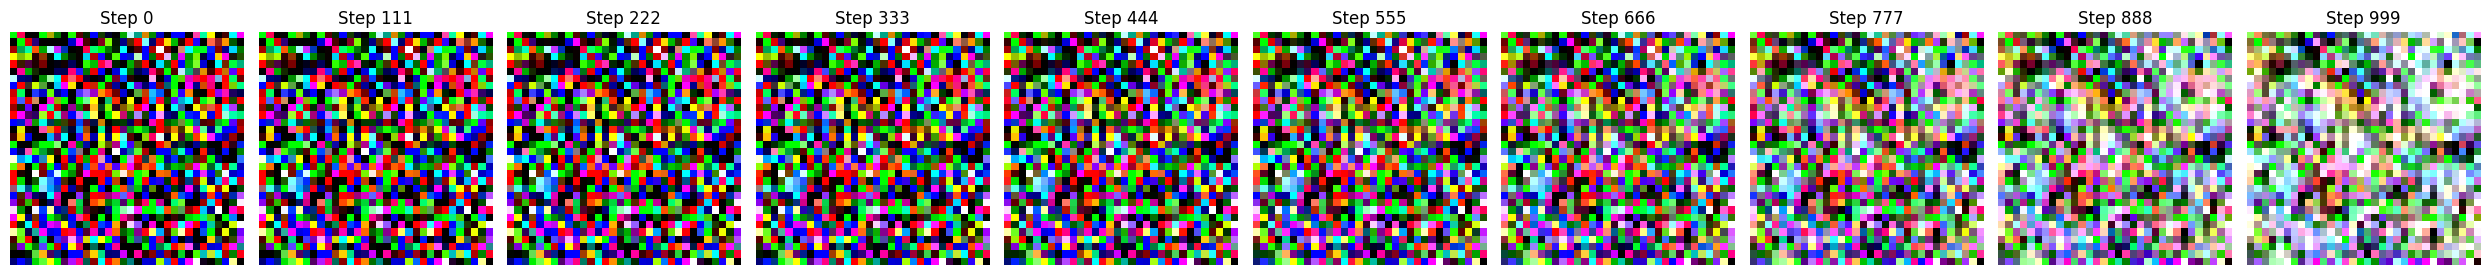

In [20]:
import matplotlib.pyplot as plt
import torch

def visualize_image_evolution(sol, id_image_to_visualize, number_of_steps, title_prefix='Step'):
    """
    sol: torch.Tensor of shape [num_steps, num_images, C, H, W]
    id_image_to_visualize: int, the image index to visualize
    number_of_steps: int, how many time steps to visualize
    """
    images = sol[:number_of_steps, id_image_to_visualize]  # [number_of_steps, C, H, W]
    C = images.shape[1]

    plt.figure(figsize=(2.5*number_of_steps, 3))
    for i in range(number_of_steps):
        img = images[i]
        # If image is torch tensor, move to cpu and convert to numpy
        if torch.is_tensor(img):
            img = img.detach().cpu()
        # Convert [C,H,W] to [H,W,C] for matplotlib if 3 channels
        if C == 3:
            img = img.permute(1,2,0).numpy()
        elif C == 1:
            img = img.squeeze().numpy()
        else:
            raise ValueError("Only supports grayscale or RGB images.")

        plt.subplot(1, number_of_steps, i+1)
        plt.imshow(img, cmap=None if C==3 else 'gray')
        plt.axis('off')
        plt.title(f"{title_prefix} {i}")

    plt.tight_layout()
    plt.show()
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_image_evolution(sol, id_image_to_visualize, number_of_steps, n_plots=10, title_prefix='Step'):
    """
    sol: torch.Tensor of shape [num_steps, num_images, C, H, W]
    id_image_to_visualize: int, the image index to visualize
    number_of_steps: int, total number of time steps available
    n_plots: int, number of images to plot (default 10)
    """
    images = sol[:number_of_steps, id_image_to_visualize]  # [number_of_steps, C, H, W]
    C = images.shape[1]

    # Compute indices to plot (equally spaced)
    if n_plots > number_of_steps:
        raise ValueError(f"n_plots ({n_plots}) > number_of_steps ({number_of_steps})")
    plot_indices = np.linspace(0, number_of_steps-1, n_plots, dtype=int)

    plt.figure(figsize=(2.5 * n_plots, 3))
    for j, i in enumerate(plot_indices):
        img = images[i]
        # If image is torch tensor, move to cpu and convert to numpy
        if torch.is_tensor(img):
            img = img.detach().cpu()
        # Convert [C,H,W] to [H,W,C] for matplotlib if 3 channels
        if C == 3:
            img = img.permute(1,2,0).numpy()
        elif C == 1:
            img = img.squeeze().numpy()
        else:
            raise ValueError("Only supports grayscale or RGB images.")

        plt.subplot(1, n_plots, j+1)
        plt.imshow(img, cmap=None if C==3 else 'gray')
        plt.axis('off')
        plt.title(f"{title_prefix} {i}")

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_image_evolution(sol, id_image_to_visualize=2, number_of_steps=number_of_steps, n_plots=10)
